In [83]:
import numpy as np
import pandas as pd 
import os

In [88]:
df = pd.read_csv(r'C:\Users\warag\OneDrive\Bureau\Transfers_Rumors\data\rumors.csv')
df.head()

,Unnamed: 0,filename,date,player,rumors
0,0,4GuMWHaJh_g.json,2024/10/05,Rudiger,Free transfer
1,1,4GuMWHaJh_g.json,2024/10/05,Juan Martinez,Transfer to Real Madrid
2,2,4GuMWHaJh_g.json,2024/10/05,Inter Milan,Inter Milan has been mentioned as a potential ...
3,3,4GuMWHaJh_g.json,2024/10/05,Paul Pogba,Set to return to professional football
4,4,4GuMWHaJh_g.json,2024/10/05,Ferland Mendy Mende,Real Madrid has set to extend the contract of ...


In [94]:
df['rumors'] = df['rumors'].str.strip('[]')
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y/%m/%d')
df = df[df['rumors'] != "transfer information not found."]


In [ ]:
# pd.set_option('display.max_rows', None)

rename_map = {
    'Nico': 'Nico williams',
    'Merino': 'Mikel Merino'}
df['player'] = df['player'].replace(rename_map)
counts_df = df['player'].value_counts().reset_index()
counts_df.columns = ['player', 'count']
print(counts_df)


                                                player  count
0                                          Real Madrid     24
1                                       Victor Osimhen     16
2                               Trent Alexander-Arnold     13
3                                                Milan     12
4                                         Jadon Sancho     12
5                                      Conor Gallagher      9
6                                             Juventus      9
7                                        Dani Carvajal      9
8                                        Nico williams      9
9                                      Fabrizio Romano      8
10                                       Romelu Lukaku      8
11                                        Ruben Amorim      8
12                                         Aston Villa      8
13                                     Virgil van Dijk      8
14                                         Inter Milan      7
15      

In [91]:
import spacy

nlp = spacy.load("en_core_web_trf")

def extract_orgs(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    orgs = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    return list(set(orgs))  # unique org names

df['keywords'] = df['rumors'].apply(extract_orgs)


c:\Users\warag\AppData\Local\Programs\Python\Python311\Lib\site-packages\thinc\shims\pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

In [92]:
df_teams = pd.read_csv(r'C:\Users\warag\OneDrive\Bureau\Transfers_Rumors\rumours.csv')


In [ ]:
mapping = dict(zip(df_teams['PlayerName'].str.lower(), df_teams['CurrentTeam']))
def get_team(player):
    return mapping.get(player.lower(), '')

df['play_at'] = df['player'].apply(get_team)


In [101]:
import json

json_comment_map = {}

# Replace this path with the actual folder path of your JSON files
json_folder = r'C:\Users\warag\OneDrive\Bureau\Transfers_Rumors\video_data\mistral'

for filename in df['filename'].unique():
    path = os.path.join(json_folder,filename)
    try:
        with open(path, 'r', encoding='utf-8') as f:
            comments = json.load(f)  # assuming JSON is a list of comments
            json_comment_map[filename] = comments['comments']
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        json_comment_map[filename] = []


In [104]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def build_filter_keywords(row):
    keywords = set()
    player_name = row['player'].lower()
    keywords.add(player_name)
    keywords.update(player_name.split())
    if pd.notna(row['play_at']) and row['play_at'].strip():
        keywords.add(row['play_at'].lower())
    if isinstance(row['keywords'], list):
        keywords.update(k.lower() for k in row['keywords'] if isinstance(k, str))
    return keywords

def compute_player_sentiment(row):
    comments = json_comment_map.get(row['filename'], [])
    keywords = build_filter_keywords(row)
    filtered = [c for c in comments if any(kw in c.lower() for kw in keywords)]
    if not filtered:
        return 0.0
    combined_text = " ".join(filtered)
    score = analyzer.polarity_scores(combined_text)
    return score['compound']

df['sentiment'] = df.apply(compute_player_sentiment, axis=1)


C:\Users\warag\AppData\Local\Temp\ipykernel_2524\2989628533.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df.apply(compute_player_sentiment, axis=1)


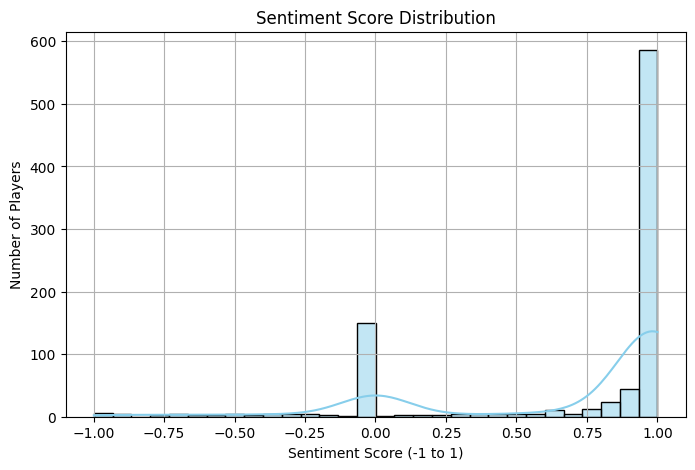

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.histplot(df['sentiment'], bins=30, kde=True, color='skyblue')

plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score (-1 to 1)')
plt.ylabel('Number of Players')
plt.grid(True)
plt.show()


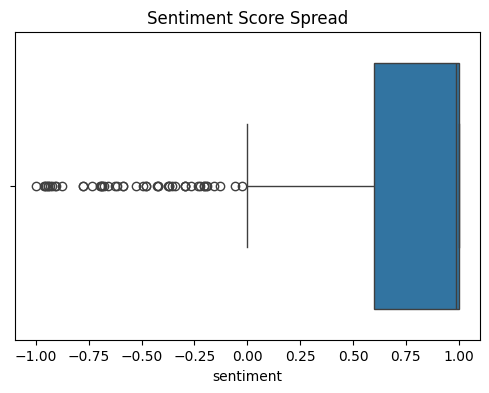

In [109]:
plt.figure(figsize=(6,4))
sns.boxplot(x=df['sentiment'])
plt.title('Sentiment Score Spread')
plt.show()


In [115]:
df.columns

Index(['filename', 'date', 'player', 'rumors', 'keywords', 'play_at',
       'sentiment'],
      dtype='object')

In [116]:
df.to_csv('rumors.csv')

